# Matched Radar/Microphysics Cross Sections

Plot a leg of collocated radar and microphysics data from IMPACTS. Uses several of the ```impacts_tools``` modules.

In [1]:
import sys
import glob
import xarray as xr
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import proplot as pplt
pplt.rc.update(
    suptitlesize=16, suptitleweight='bold', fontsize=14, ticklabelsize=14,
    ticklen=8, ticklenratio=0.5, colorbarwidth='1em',
    figurefacecolor='w', savefigtransparent=False
)

sys.path.append('/home/disk/meso-home/jfinlon/impacts/github/impacts_tools/src')
from impacts_tools import p3, er2, match, legs, radar_cmaps

Some subroutines.

In [2]:
def trim_er2_times(start_time, end_time, trim_start='1Min', trim_end='1Min'):
    '''
    Generates start/end times based on the P-3 segment to additionally trim the radar data.
    The ER-2 typically started/completed it's turns when the P-3 started/ended a leg,
    so trimming the data is ideal as roll angles were large.
    '''
    start_trim = (
        pd.Timestamp(start_time) + pd.Timedelta(trim_start)
    ).strftime('%Y-%m-%dT%H:%M:%S')
    end_trim = (
        pd.Timestamp(end_time) - pd.Timedelta(trim_end)
    ).strftime('%Y-%m-%dT%H:%M:%S')
    
    return (start_trim, end_trim)

def xsection_grid(x_grid, y_grid):
    '''
    Adds an extra element in the time/distance and height dimension to conform to newer mpl pcolormesh() function.
    Useful for plotting ER-2 radar cross sections.
    
    Parameters
    ----------
    x_grid: 2D time or distance field created from er2read() or resample() subroutines.
    y_grid: 2D height field created from er2read() or resample() subroutines.
    '''
    
    # Work with x coordinate (time/distance) first
    xdelta = x_grid[0, -1] - x_grid[0, -2] # should work on time and float dtypes
    vals_to_append = np.atleast_2d(np.tile(x_grid[0,-1] + xdelta, x_grid.shape[0])).T
    x_regrid = np.hstack((x_grid, vals_to_append)) # add column
    x_regrid = np.vstack((np.atleast_2d(x_regrid[0,:]), x_regrid)) # add row
    
    # Now do the y coordinate (height)
    ydelta = y_grid[0, :] - y_grid[1, :] # height difference between first and second gates
    vals_to_append = np.atleast_2d(y_grid[0,:] + ydelta)
    y_regrid = np.vstack((vals_to_append, y_grid)) # add row
    y_regrid = np.hstack((y_regrid, np.atleast_2d(y_regrid[:,-1]).T))
    
    return x_regrid, y_regrid

# Example 14/15 February 2023 Flight Segment

First get the leg times and filenames.

In [3]:
date = '2023-02-14'
datestr = date.replace('-', '')
leg_times = legs.time_bounds(date)
fname_p3 = glob.glob(
    f'/home/disk/bob/impacts/microphysics/{datestr}/IWG*'
)[0] # P-3 IWG data
fname_hiwrap = sorted(
    glob.glob(
        '/home/disk/bob/impacts/er2/HIWRAP/hdfFiles/'
        f'*RevDraft_{datestr}.h5'       
    ), reverse=True
) # L1B HIWRAP data
fname_hrrr = (
    f'/home/disk/bob/impacts/raw/hrrr/hiwrap_grid/hrrr.hiwrap_grid.{datestr}.nc'
) # HRRR properties on HIWRAP grid
fname_hvps = (
    f'/home/disk/bob/impacts/microphysics/{datestr}/sd_data/'
    f'sd_v1.{datestr}.HVPS.V.nc'
) # UIOOPS HVPS PSD

### For the 01:26:00-01:49:30 UTC 15 Feb 2023 flight segment:  
- Load the HIWRAP and gridded HRRR data for the interval  
- Match the HIWRAP Z and Doppler to the P-3 aircraft  
- Read the PSD data and compute bulk properties using scattering data from most optimal m-D (requires ```pytmatrix```)

In [4]:
start, end = leg_times[3]
start_dt64, end_dt64 = np.array([start, end], dtype='datetime64[ns]')
start_er2, end_er2 = np.array(
    list(trim_er2_times(start, end)), dtype='datetime64[ns]'
)

if date == '2023-02-14': # special case as some nav data was missing
    p3nav = p3.P3(
        fname_p3, date, start_time=start, end_time=end, tres='1S', fmt='iwg'
    )
    interp_times = pd.date_range(start, end, freq='1S')
    interp_times.freq = None
    p3nav.data = p3nav.data.interp(time=interp_times).resample(time='5S').mean(dim='time')
elif ('2020' in date) or ('2022' in date):
    p3nav = p3.P3(
        fname_p3, date, start_time=start, end_time=end, tres='5S', fmt='ames'
    )
elif '2023' in date:
    p3nav = p3.P3(
        fname_p3, date, start_time=start, end_time=end, tres='5S', fmt='iwg'
    )

hiwrap = er2.Hiwrap(
    fname_hiwrap, atten_file=fname_hrrr,
    start_time=start_er2, end_time=end_er2,
    dataset='2022', dbz_sigma=1, width_sigma=1
)
match_hiwrap = match.Hiwrap(
    hiwrap.data, p3nav.data, query_k=30, dist_thresh=4000., time_thresh=300.,
    qc=True, ref_coords=None, n_workers=4
)

hrrr = xr.open_dataset(fname_hrrr).interp_like(hiwrap.data)

psd = p3.Psd(
    None, fname_hvps, date, binlims=(0.4, 30), p3_object=p3nav, calc_bulk=True,
    dbz_matched=(None, match_hiwrap.data.dbz_ku, match_hiwrap.data.dbz_ka, None)
)

# build the P-3 track
valid_inds = ~np.isnan(match_hiwrap.data.dbz_ku - match_hiwrap.data.dbz_ka)
p3_x = match_hiwrap.data.distance.where(valid_inds, drop=True).values / 1000. # km
p3_y = p3nav.data.alt_gps.where(valid_inds, drop=True).values / 1000. # km

# mask PSD periods with no mached radar data
psd_match = psd.data.where(valid_inds, drop=True)

Plot the radar cross section, matched radar data, and some microphysics data along a common ER-2 distance-relative scale.

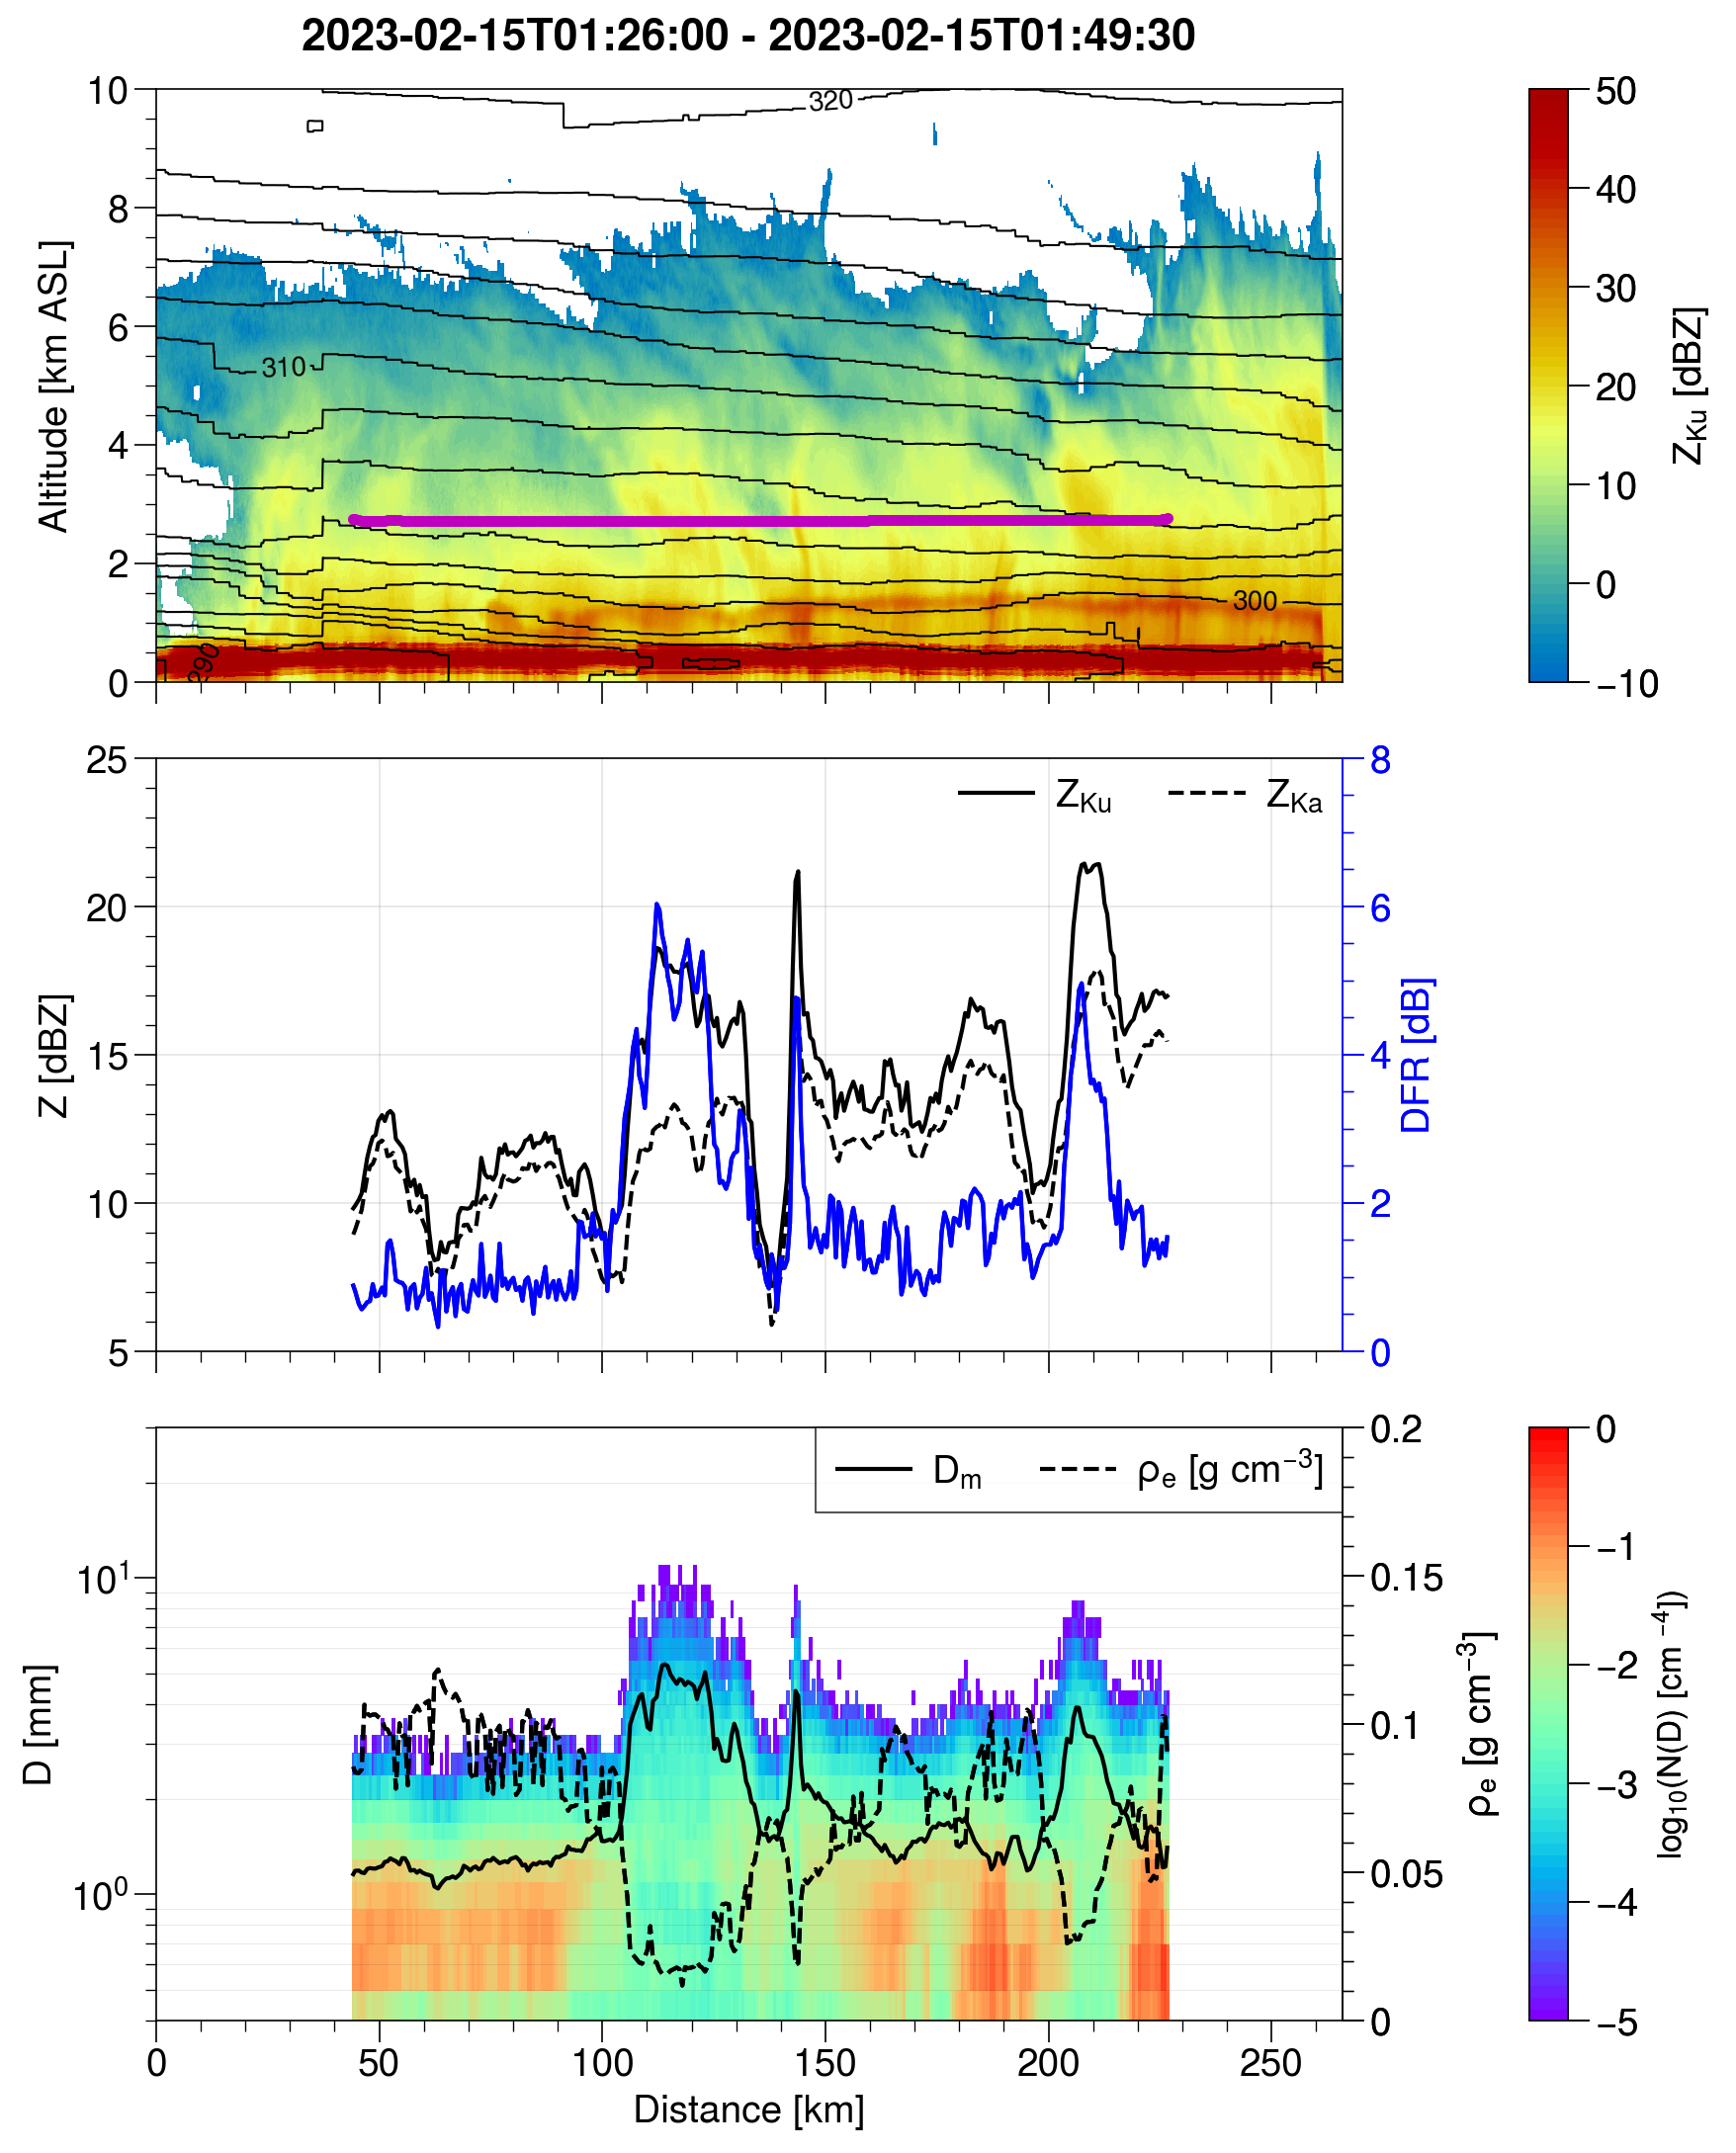

In [5]:
[X, Y] = xsection_grid(
    np.tile(
        np.atleast_2d(hiwrap.data.distance - hiwrap.data.distance[0]),
        (hiwrap.data.height.shape[0], 1)
    ) / 1000., hiwrap.data.height / 1000.
) # generate meshgrid for plotting

fig, axs = pplt.subplots(
    nrows=3, refwidth=6, refaspect=2, sharey=False,
    suptitle=f'{start} - {end}'
)

ax = axs[0]
ax.pcolormesh(
    X, Y, hiwrap.data.dbz_ku, levels=np.linspace(-10, 50, 61),
    cmap='radar_HomeyerRainbow', colorbar='r', colorbar_kw={
        'ticks': 10, 'label': 'Z$_{Ku}$ [dBZ]'}, rasterized=True
)
ax.contour(
    X, Y, hrrr['ept'], levels=np.linspace(240, 360, 61),
    color='k', lw=0.75, ls='-', labels=True, 
    labels_kw={'size':10, 'levels':np.linspace(240, 360, 13)}
)
ax.plot(
    p3_x, p3_y, 'm.', label='P-3 Track', lw=2
)
ax.format(ylim=(0, 10), ylabel='Altitude [km ASL]')

# -------------
ax = axs[1]
ax.plot(
    match_hiwrap.data.distance / 1000., match_hiwrap.data.dbz_ku,
    'k-', label='Z$_{Ku}$'
)
ax.plot(
    match_hiwrap.data.distance / 1000., match_hiwrap.data.dbz_ka,
    'k--', label='Z$_{Ka}$'
)
ax.legend(loc='best', fontsize=12, frame=False)
ax.format(ylim=(5, 25), ylabel='Z [dBZ]')
axb = ax.twinx(ycolor='b')
axb.plot(
    match_hiwrap.data.distance / 1000.,
    match_hiwrap.data.dbz_ku - match_hiwrap.data.dbz_ka,
    'b-'
)
axb.format(ylim=(0, 8), ylabel='DFR [dB]')

# -------------
ax = axs[2]
ax.pcolormesh(
    psd_match.distance / 1000., psd_match.bin_left, np.log10(psd_match.ND),
    levels=np.linspace(-5, 0, 51), cmap='rainbow', colorbar='r',
    colorbar_kw={
        'ticks':1, 'width':'1em', 'extendsize':'0em',
        'labelsize':12, 'label':'log$_{10}$(N(D) [cm $^{-4}$])'
    }
)
ax.plot(
    psd_match.distance / 1000., psd_match.dm_ls, 'k-', label='D$_m$'
)
ax.plot([], [], 'k--', label=r'$\rho_e$ [g cm$^{-3}$]') # dummy line for legend
ax.legend(loc='ur', fontsize=12, frame=True)
ax.format(
    ylim=(0.4, 30.), yscale='log', yformatter='log', ylabel='D [mm]',
    ygridminor=True
)
axb = ax.twinx()
axb.plot(psd_match.distance / 1000., psd_match.rhoe_ls, 'k--')
axb.format(ylim=(0, 0.2), ylabel=r'$\rho_e$ [g cm$^{-3}$]')

axs.format(xlabel='Distance [km]', xlim=(np.min(X), np.max(X)))